# EDSR Super-Resolution Training and Inference

This notebook demonstrates how to train an EDSR model using paired low-resolution (LR) and high-resolution (HR) images, save the trained model, reload it, and perform inference.

In [46]:
# Import required libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, Lambda
from tensorflow.keras.models import Model

## Define EDSR Model

In [47]:
# Define pixel shuffle as a named function for Lambda layer
def pixel_shuffle(x):
    return tf.nn.depth_to_space(x, 2)

def edsr(scale=4, num_res_blocks=8, res_block_filters=64, input_shape=(None, None, 3)):
    def res_block(x_in):
        x = Conv2D(res_block_filters, 3, padding='same', activation='relu')(x_in)
        x = Conv2D(res_block_filters, 3, padding='same')(x)
        x = Add()([x_in, x])
        return x

    x_in = Input(shape=input_shape)
    x = Conv2D(res_block_filters, 3, padding='same')(x_in)
    x_res = x
    for _ in range(num_res_blocks):
        x_res = res_block(x_res)
    x = Add()([x, x_res])
    x = Conv2D(res_block_filters * (scale ** 2), 3, padding='same')(x)
    x = Lambda(pixel_shuffle)(x)
    x = Conv2D(3, 3, padding='same')(x)
    model = Model(x_in, x)
    return model

## Data Loader for HR/LR Image Pairs

In [48]:
def load_image_pair(lr_path, hr_path):
    lr = cv2.imread(lr_path)
    hr = cv2.imread(hr_path)
    lr = cv2.cvtColor(lr, cv2.COLOR_BGR2RGB)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
    return lr, hr

def load_dataset(lr_dir, hr_dir, max_images=None, target_size=(64, 64)):
    lr_files = sorted([f for f in os.listdir(lr_dir) if f.lower().endswith(('png','jpg','jpeg'))])
    hr_files = sorted([f for f in os.listdir(hr_dir) if f.lower().endswith(('png','jpg','jpeg'))])
    X, Y = [], []
    for i, (lr_file, hr_file) in enumerate(zip(lr_files, hr_files)):
        if max_images and i >= max_images:
            break
        lr, hr = load_image_pair(os.path.join(lr_dir, lr_file), os.path.join(hr_dir, hr_file))
        # Resize both LR and HR images to target_size
        lr_resized = cv2.resize(lr, (target_size[0], target_size[1]), interpolation=cv2.INTER_CUBIC)
        hr_resized = cv2.resize(hr, (target_size[0]*2, target_size[1]*2), interpolation=cv2.INTER_CUBIC)
        X.append(lr_resized)
        Y.append(hr_resized)
    X = np.array(X, dtype=np.float32) / 255.0
    Y = np.array(Y, dtype=np.float32) / 255.0
    return X, Y

## Load Training Data

In [ ]:
lr_dir = 'dataset/images/train_lr'
hr_dir = 'dataset/images/train_hr'

# Load a small subset for demonstration (remove max_images for full dataset)
X_train, Y_train = load_dataset(lr_dir, hr_dir, max_images=20, target_size=(256, 256))
print(f'Loaded {X_train.shape[0]} image pairs. LR shape: {X_train.shape[1:]}, HR shape: {Y_train.shape[1:]}')

Loaded 10 image pairs. LR shape: (256, 256, 3), HR shape: (512, 512, 3)


## Train EDSR Model

In [50]:
edsr_model = edsr(scale=2, num_res_blocks=8, res_block_filters=64, input_shape=X_train.shape[1:])
edsr_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mae')

# Add EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train for a few epochs for demonstration (increase epochs for real training)
edsr_model.fit(
    X_train, Y_train,
    batch_size=4,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - loss: 0.7162 - val_loss: 0.5456
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 0.5029 - val_loss: 0.3106
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 0.2681 - val_loss: 0.2346
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 0.1956 - val_loss: 0.1045
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.1056 - val_loss: 0.0896
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.0832 - val_loss: 0.0713
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.0682 - val_loss: 0.0545
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.0526 - val_loss: 0.0493
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.0469 - val_loss: 0.0422
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.0412 - val_loss: 0.0417
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - loss: 0.0396 - val_loss: 0.0371
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - loss: 0.0356 - val_loss: 0.0369
E

KeyboardInterrupt: 

## Save the Trained Model

In [ ]:
edsr_model.save('edsr_model.h5')

## Reload the Model

In [ ]:
# When loading the model, provide pixel_shuffle in custom_objects
from tensorflow.keras.models import load_model
edsr_loaded = load_model('edsr_model.h5', compile=False, custom_objects={'pixel_shuffle': pixel_shuffle})

## Inference on a Sample LR Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


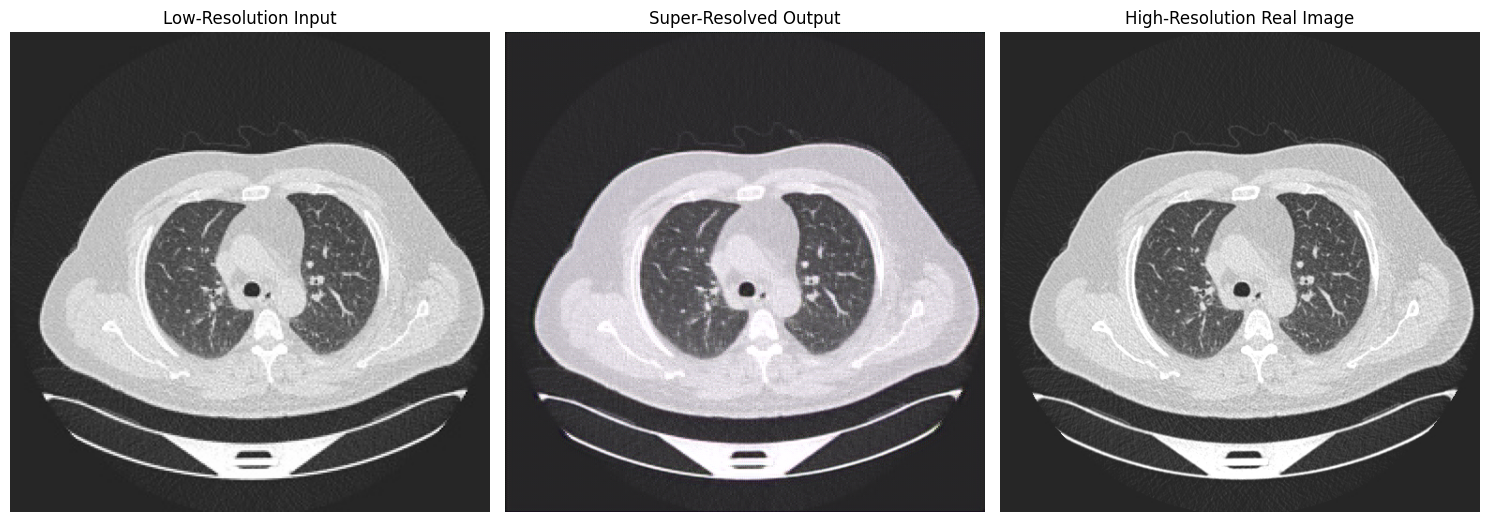

Super-resolved image saved to: dataset/images/output/Bengin case (93).jpg


In [ ]:
# Pick a sample LR image from the training set
image_number = 2
sample_lr = X_train[image_number]
# print(f"Selected image number: {sample_lr}")
# Model expects batch dimension
input_img = np.expand_dims(sample_lr, axis=0)

# Predict HR image
sr_img = edsr_loaded.predict(input_img)[0]
sr_img = np.clip(sr_img, 0, 1)

# Display LR, SR, and HR images stacked horizontally
plt.figure(figsize=(15, 6))  # Increase width for horizontal stacking
plt.subplot(1,3,1)
plt.imshow(sample_lr)
plt.title('Low-Resolution Input')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(sr_img)
plt.title('Super-Resolved Output')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(Y_train[image_number])
plt.title('High-Resolution Real Image')
plt.axis('off')
plt.tight_layout()
plt.show()

# Save the super-resolved image to output folder with the same name
output_dir = 'dataset/images/output'
os.makedirs(output_dir, exist_ok=True)
output_fname = os.listdir(lr_dir)[image_number]
output_path = os.path.join(output_dir, output_fname)
cv2.imwrite(output_path, cv2.cvtColor((sr_img * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print(f"Super-resolved image saved to: {output_path}")